In [1]:
#importy
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
import joblib  

In [2]:
#cesta
CSV_PATH = Path(r"C:\Users\adria\PycharmProjects\pythonProject\ZNEUS\PROJEKT\houses.csv")
CSV_PATH


WindowsPath('C:/Users/adria/PycharmProjects/pythonProject/ZNEUS/PROJEKT/houses.csv')

# EDA - Data analysis

### Load dataset

In [3]:
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
display(df.head(10))


Shape: (20640, 9)


,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
5,269700.0,4.0368,52.0,919.0,213.0,413.0,193.0,37.85,-122.25
6,299200.0,3.6591,52.0,2535.0,489.0,1094.0,514.0,37.84,-122.25
7,241400.0,3.1200,52.0,3104.0,687.0,1157.0,647.0,37.84,-122.25
8,226700.0,2.0804,42.0,2555.0,665.0,1206.0,595.0,37.84,-122.26
9,261100.0,3.6912,52.0,3549.0,707.0,1551.0,714.0,37.84,-122.25


### Dtypes, missing, duplicates

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None

In [5]:
print("Dtypes, missing counts")
dtypes_missing = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing_count": df.isna().sum(),
    "missing_rate": (df.isna().mean()).round(4),
    "unique_count": df.nunique(dropna=True)
}).sort_values("missing_count", ascending=False)
display(dtypes_missing)

dups = df.duplicated().sum()
print("Duplicated rows:", dups)


Dtypes, missing counts


,dtype,missing_count,missing_rate,unique_count
median_house_value,float64,0,0.0,3842
median_income,float64,0,0.0,12928
housing_median_age,float64,0,0.0,52
total_rooms,float64,0,0.0,5926
total_bedrooms,float64,0,0.0,1928
population,float64,0,0.0,3888
households,float64,0,0.0,1815
latitude,float64,0,0.0,862
longitude,float64,0,0.0,844


Duplicated rows: 0


### Statistics for numeric columns

In [6]:
num = df.select_dtypes(include=[np.number])
if num.shape[1] > 0:
    display(num.describe().T)
else:
    print("No numeric columns found.")


,count,mean,std,min,25%,50%,75%,max
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,537.898014,421.247906,1.0000,295.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100


In [7]:
maxv = df['median_house_value'].max()
print("Max value:", maxv, " Count:", (df['median_house_value']==maxv).sum())
df['is_censored'] = (df['median_house_value']==maxv).astype(int)
df['is_censored'].value_counts()


Max value: 500001.0  Count: 965


is_censored
0    19675
1      965
Name: count, dtype: int64

In [8]:
if num.shape[1] > 0:
    iqr = num.quantile(0.75) - num.quantile(0.25)
    range_ = num.max() - num.min()
    outlier_flag = (range_ / (iqr.replace(0, np.nan))).sort_values(ascending=False).head(10)
    print("\nTop features by range / IQR (may indicate heavy tails or outliers):")
    display(outlier_flag)
else:
    print("No numeric columns found.")


Top features by range / IQR (may indicate heavy tails or outliers):


population            38.037313
total_rooms           23.124835
households            18.710769
total_bedrooms        18.306818
median_income          6.651926
median_house_value     3.341960
housing_median_age     2.684211
longitude              2.649077
latitude               2.489418
dtype: float64

### Correlation matrix for numeric features

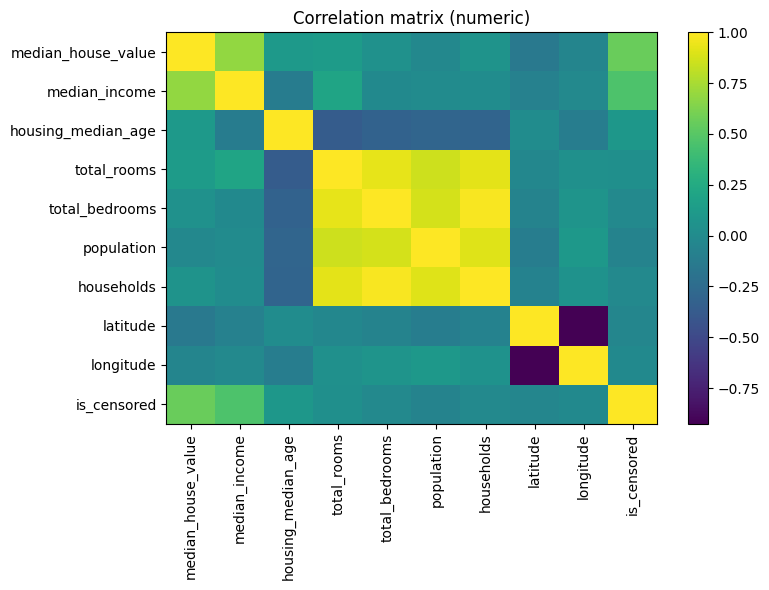

In [9]:
num = df.select_dtypes(include=[np.number])
if num.shape[1] >= 2:
    corr = num.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation="nearest", aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation matrix (numeric)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.")


In [10]:
target = "median_house_value"
if target in corr.columns:
    target_corr = corr[target].drop(target).abs().sort_values(ascending=False)
    print("Top features by absolute correlation with target:")
    display(target_corr.head(10))
else:
    print("Target not in numeric columns for correlation.")

Top features by absolute correlation with target:


median_income         0.688075
is_censored           0.562614
latitude              0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.050594
longitude             0.045967
population            0.024650
Name: median_house_value, dtype: float64

### Target distribution

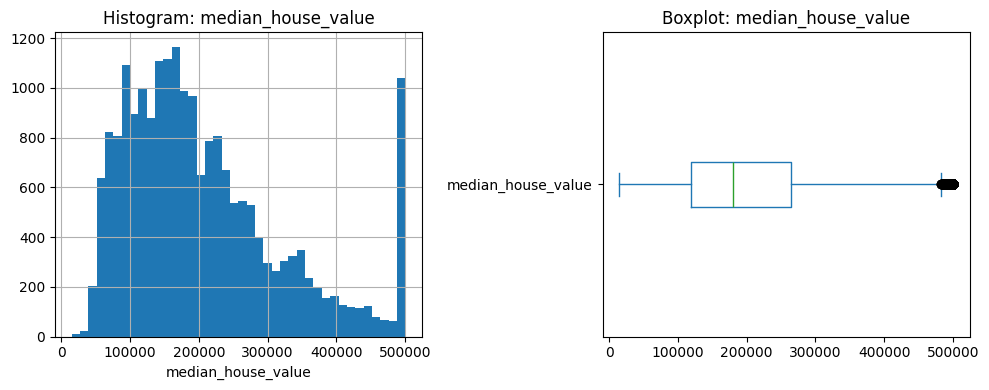

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df[target].dropna().hist(bins=40)
plt.title(f"Histogram: {target}")
plt.xlabel(target)

plt.subplot(1,2,2)
df[target].dropna().plot.box(vert=False)
plt.title(f"Boxplot: {target}")

plt.tight_layout()
plt.show()


In [12]:
skew = num.skew().sort_values(ascending=False)
display(skew)

population            4.935858
is_censored           4.294220
total_rooms           4.147343
total_bedrooms        3.453073
households            3.410438
median_income         1.646657
median_house_value    0.977763
latitude              0.465953
housing_median_age    0.060331
longitude            -0.297801
dtype: float64

In [13]:
kurtosis = num.kurtosis().sort_values(ascending=False)
display(kurtosis)

population            73.553116
total_rooms           32.630927
households            22.057988
total_bedrooms        21.923495
is_censored           16.441921
median_income          4.952524
median_house_value     0.327870
housing_median_age    -0.800629
latitude              -1.117760
longitude             -1.330152
dtype: float64

#### Scatter and Pair plots for top numeric features correlated with target

Top numeric features vs target: ['median_income', 'is_censored', 'latitude']


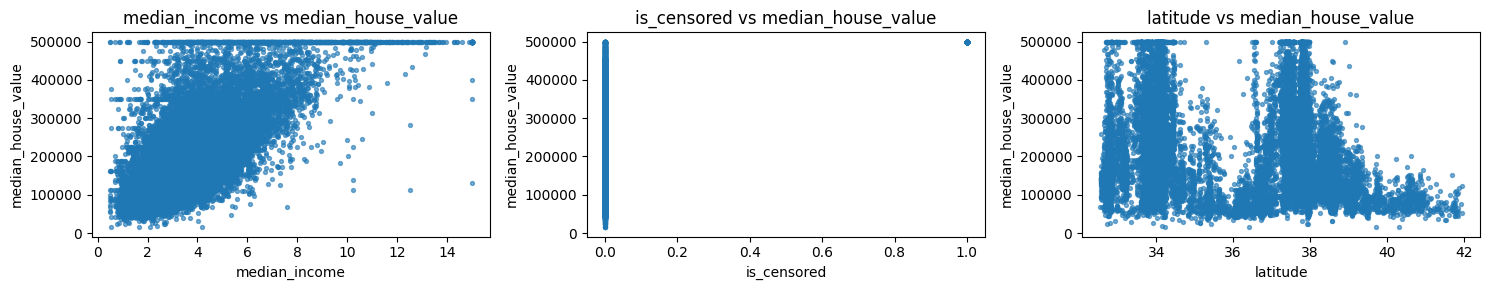

In [14]:
if target in num.columns:
    corr_with_target = num.corr()[target].abs().drop(target).sort_values(ascending=False)
    top_feats = corr_with_target.head(3).index.tolist()
    print("Top numeric features vs target:", top_feats)
    n = len(top_feats)
    if n > 0:
        plt.figure(figsize=(5*n,3))
        for i, f in enumerate(top_feats,1):
            plt.subplot(1,n,i)
            plt.scatter(df[f], df[target], s=8, alpha=0.6)
            plt.xlabel(f); plt.ylabel(target)
            plt.title(f"{f} vs {target}")
        plt.tight_layout()
        plt.show()
else:
    print("Target not numeric or no numeric features.")


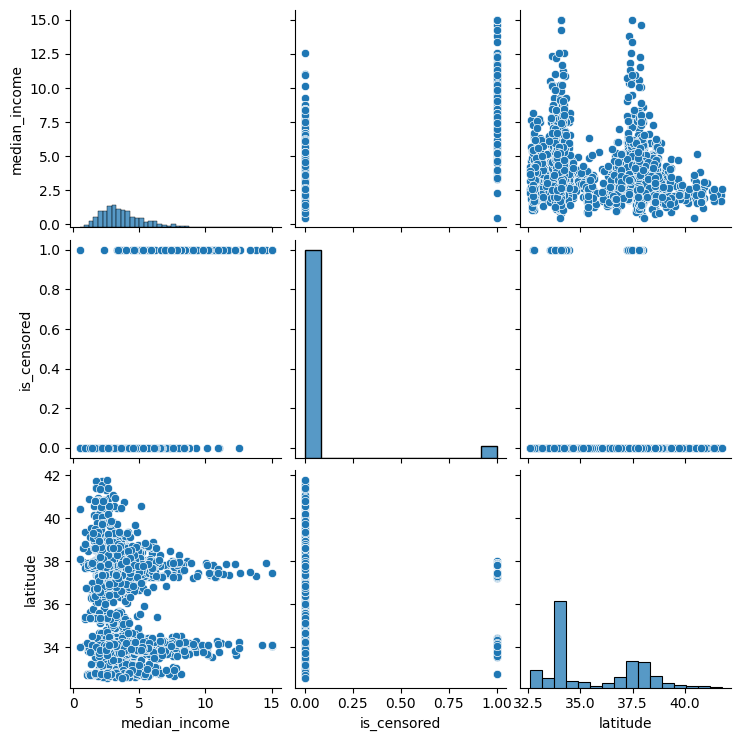

In [15]:
sns.pairplot(df.sample(2000)[top_feats])

### Region exploration

In [16]:
coords = df[['latitude','longitude']]
km = KMeans(n_clusters=8, random_state=0).fit(coords)
df['region_id'] = km.labels_
df.groupby('region_id')['median_house_value'].median().sort_values()


region_id
2     76400.0
4     85800.0
6     89000.0
3    117800.0
7    169650.0
5    181600.0
0    198400.0
1    245100.0
Name: median_house_value, dtype: float64

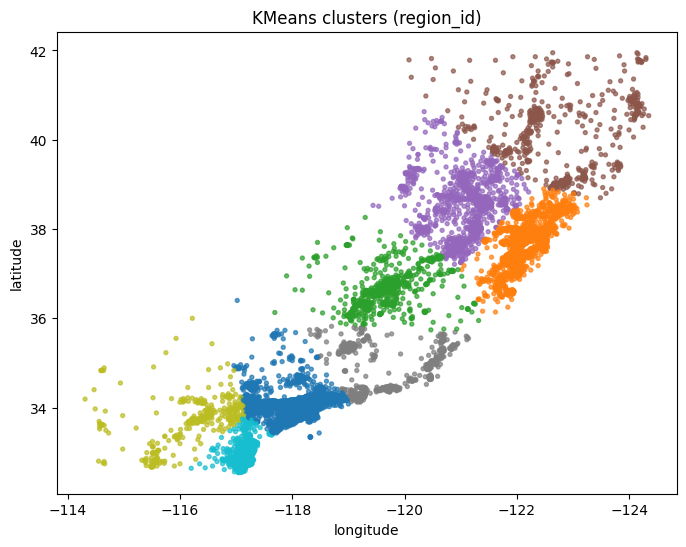

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(df['longitude'], df['latitude'], c=df['region_id'], s=8, cmap='tab10', alpha=0.7)
plt.gca().invert_xaxis()
plt.title("KMeans clusters (region_id)")
plt.xlabel("longitude"); plt.ylabel("latitude")
plt.show()

In [18]:
df.groupby('region_id', observed=False)['median_house_value'].agg(['count','median','mean']).sort_values('median')

,count,median,mean
region_id,,,
2,1117,76400.0,86213.249776
4,685,85800.0,92102.916788
6,474,89000.0,106898.529536
3,2203,117800.0,127250.976396
7,1678,169650.0,198141.446365
5,986,181600.0,191438.676471
0,8652,198400.0,229496.027624
1,4845,245100.0,262594.436739


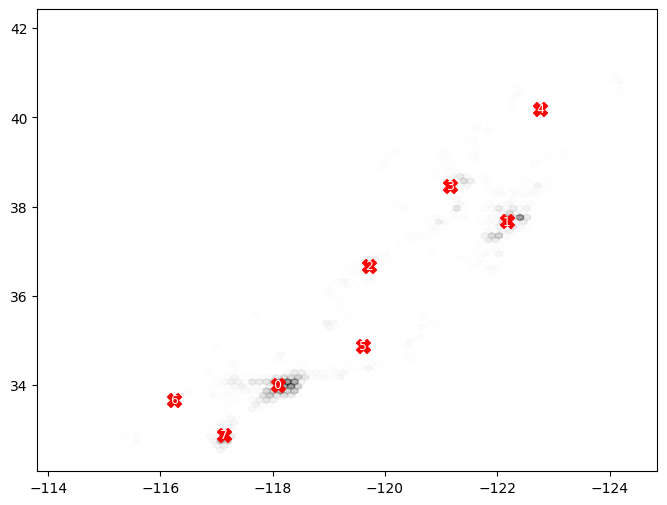

In [19]:
centroids = km.cluster_centers_ 
plt.figure(figsize=(8,6))
plt.hexbin(df["longitude"], df["latitude"], gridsize=80, mincnt=1, cmap='Greys', alpha=0.4)
plt.scatter(centroids[:,1], centroids[:,0], c='red', s=100, marker='X') 
for i,(lon,lat) in enumerate(zip(centroids[:,1], centroids[:,0])):
    plt.text(lon, lat, str(i), color='white', fontsize=9, ha='center', va='center')
plt.gca().invert_xaxis()
plt.show()


### Categorical check

In [20]:
categ = df.select_dtypes(include=["object","category"]).columns.tolist()
if not categ:
    print("No categorical columns found.")
else:
    for c in categ:
        print(f"\nColumn: {c} | Unique: {df[c].nunique()}")
        print(df[c].value_counts().head(5))


No categorical columns found.


# EDA zhrnutie:

- **Veľkosť a čistota dát:** 20 640 riadkov, 9 stĺpcov. V EDA žiadne chýbajúce hodnoty a 0 úplných duplicitných riadkov — dáta sú kompletné a pripravené na ďalšiu analýzu.

- **Cieľ — `median_house_value`:**
  - mean ≈ **206 856**, median ≈ **179 700**, veľký rozptyl.  
  - max = **500001.0**, počet pri maxime = **965**  

- **Hlavné prediktory (lineárne):**
  - `median_income` má najsilnejšiu pozitívnu koreláciu s cenou (~**0.69**) — kľúčový prediktor.  
  - Ďalej sú relevantné priestorové prvky (`latitude`/`longitude`) a štrukturálne metriky domu `total_rooms`...

- **Outliery a šikmosť:**
  - Stĺpce `population`, `total_rooms`, `households`, `total_bedrooms` majú veľký `range / IQR` a vysoký skew → silné chvosty.  
  - `median_house_value` skew ≈ **0.98** (pravostranný).

- **Vizualizácie a priestorový vzor:**
  - Scatter / pairplot potvrdili silný trend `median_income` vs cena a regionálne pásy podľa `latitude`.  
  - Hexbin (longitude vs latitude) ukázal jasné **hotspoty** 

- **Regionálne klastre (KMeans, k=8):**
  - KMeans vytvoril regiony s rôznymi mediánmi
  - Veľkosti klastrov sú nerovnomerné (niektoré stovky, iné tisícky riadkov) — pri použití v modeli zohľadni nerovnomernosť.  
  - Dôležité: KMeans v EDA možno fitnúť na celom df len pre exploráciu


# Data preprocessing and normalization